# IMPORT LIBRARIES

In [230]:
import os
import torch
from helper_fuctions import accuracy_fn, eval_model, pred_and_plot_image, plot_loss_curves
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision import transforms
from pathlib import Path
from torchvision.datasets import CIFAR10
from tqdm import tqdm
import random
from PIL import Image
torch.__version__
import torch.nn.functional as F

# SETUP AGNOSTIC DEVICE

In [231]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# IMPORT DATASET

In [232]:
image_path = Path('../DogDataset')
image_path.is_dir()

True

In [233]:
image_path_list = list(image_path.glob('*/*/*.jpg'))
random_image_path = random.choice(image_path_list)
random_image_class = random_image_path.parent.stem

In [234]:
img_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.229, 0.229])
    ]
)

In [235]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_data = datasets.ImageFolder(train_dir, img_transform)
test_data = datasets.ImageFolder(test_dir, img_transform)

In [236]:
class_names = train_data.classes
class_names

['Shiba Inu', 'Shih-Tzu', 'Siberian Husky', 'Vizsla', 'Yorkie']

# Visualizing the Dataset

In [237]:
image, label = train_data[4]
image, label

(tensor([[[-1.2959, -1.3302, -1.5699,  ..., -1.5357, -1.5014, -1.2959],
          [-1.2788, -1.2788, -1.4843,  ..., -1.2617, -1.3987, -1.2788],
          [-1.2617, -1.2959, -1.3644,  ..., -1.1589, -1.3987, -1.2788],
          ...,
          [-1.3815, -1.4329, -0.7650,  ..., -1.4158, -1.6727, -1.5014],
          [-1.7925, -1.6213, -1.6213,  ..., -1.5185, -1.5870, -1.4500],
          [-1.6727, -0.8678, -1.8097,  ..., -1.6384, -0.9534, -1.5014]],
 
         [[-0.4158, -0.4500, -0.6384,  ..., -0.4500, -0.3815, -0.1932],
          [-0.3987, -0.3987, -0.5528,  ..., -0.1760, -0.2788, -0.1760],
          [-0.3815, -0.3644, -0.4329,  ..., -0.0390, -0.2788, -0.1760],
          ...,
          [-0.3130, -0.4158,  0.1836,  ..., -0.4329, -0.6898, -0.4843],
          [-0.6898, -0.5528, -0.6555,  ..., -0.5357, -0.6213, -0.5185],
          [-0.5185,  0.2007, -0.7925,  ..., -0.7069, -0.0219, -0.6042]],
 
         [[-1.1051, -1.1393, -1.3619,  ..., -1.2763, -1.1564, -0.9167],
          [-1.0537, -1.0879,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


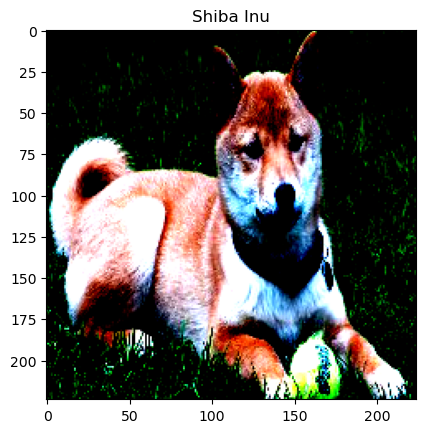

In [238]:
plt.imshow(image.squeeze().permute(1,2,0))
plt.title(class_names[label])
plt.show()

# Splitting Data

In [239]:
train_dataloader = DataLoader(train_data, 16)
test_dataloader = DataLoader(test_data, 16)
train_batch = next(iter(train_dataloader))

train_batch[0].shape

torch.Size([16, 3, 224, 224])

# CREATING A MODEL

In [240]:
class Model(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        
        self.conv1 = nn.Conv2d(input, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 24, 5)
        self.fc1 = nn.Linear(67416, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [241]:
model = Model(3, len(class_names)).to(device)
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 0.0465, -0.1096, -0.0224, -0.0722,  0.1033],
                        [ 0.0510, -0.0137,  0.0099, -0.1064, -0.0972],
                        [ 0.0359,  0.0651, -0.0295,  0.0643,  0.0757],
                        [ 0.0674, -0.0526,  0.0217, -0.0471,  0.0568],
                        [-0.0878,  0.0088,  0.1085,  0.0201,  0.0646]],
              
                       [[ 0.0425, -0.0729,  0.0788, -0.1145, -0.0474],
                        [-0.0284, -0.0180, -0.0312,  0.0443,  0.0810],
                        [-0.0533,  0.0965, -0.0635, -0.0085, -0.0797],
                        [-0.0306, -0.0607, -0.0798,  0.0509, -0.0534],
                        [-0.0099,  0.0642,  0.0189, -0.0430, -0.1035]],
              
                       [[-0.0791,  0.1110,  0.0828,  0.0553,  0.0458],
                        [-0.0317, -0.0577, -0.0492,  0.0800, -0.0485],
                        [-0.0777, -0.0413,  0.1022,  0.0680, -0.0355],
               

# TRAINING THE MODEL

In [242]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9)

In [243]:
epochs = 40

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device) 
        optim.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optim.step()
        train_loss += loss.item() * images.size(0)  


    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_images, val_labels in test_dataloader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)  # Move to GPU
            val_outputs = model(val_images)
            val_loss += loss_fn(val_outputs, val_labels).item() * val_images.size(0)  # Accumulate validation loss

    train_loss /= len(train_dataloader.dataset)
    val_loss /= len(test_dataloader.dataset)



    # Print epoch summary
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/50, Training Loss: 1.7183, Validation Loss: 1.6146
Epoch 2/50, Training Loss: 1.6159, Validation Loss: 1.6120
Epoch 3/50, Training Loss: 1.6004, Validation Loss: 1.6121
Epoch 4/50, Training Loss: 1.5878, Validation Loss: 1.6098
Epoch 5/50, Training Loss: 1.5761, Validation Loss: 1.6028
Epoch 6/50, Training Loss: 1.5643, Validation Loss: 1.5892
Epoch 7/50, Training Loss: 1.5501, Validation Loss: 1.5703
Epoch 8/50, Training Loss: 1.5347, Validation Loss: 1.5365
Epoch 9/50, Training Loss: 1.5390, Validation Loss: 1.5182
Epoch 10/50, Training Loss: 1.5001, Validation Loss: 1.4497
Epoch 11/50, Training Loss: 1.5032, Validation Loss: 1.3813
Epoch 12/50, Training Loss: 1.4429, Validation Loss: 1.2556
Epoch 13/50, Training Loss: 1.4648, Validation Loss: 1.3900
Epoch 14/50, Training Loss: 1.4549, Validation Loss: 1.1961
Epoch 15/50, Training Loss: 1.4318, Validation Loss: 1.1592
Epoch 16/50, Training Loss: 1.3547, Validation Loss: 1.1301
Epoch 17/50, Training Loss: 1.3779, Validation Lo

In [244]:
correct = 0
total = 0

model.cpu()
model.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        ypred = model(X)
        _, prediction = torch.max(ypred, 1)
        total += y.size(0)
        correct += (prediction == y).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy}%')

Accuracy: 78.0%


In [245]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [246]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([3, 224, 224])
Test sample label: 0 (Shiba Inu)


In [247]:
pred_probs= make_predictions(model=model.to(device), 
                             data=test_samples)


pred_probs[:2]

tensor([[3.1863e-01, 6.6988e-02, 8.6082e-03, 5.2543e-01, 8.0339e-02],
        [1.0598e-05, 6.4132e-08, 1.2720e-12, 9.9998e-01, 4.6145e-06]])

In [248]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([3, 3, 1, 1, 4, 2, 3, 2, 1])

In [249]:
test_labels, pred_classes

([0, 3, 1, 4, 4, 4, 3, 2, 1], tensor([3, 3, 1, 1, 4, 2, 3, 2, 1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


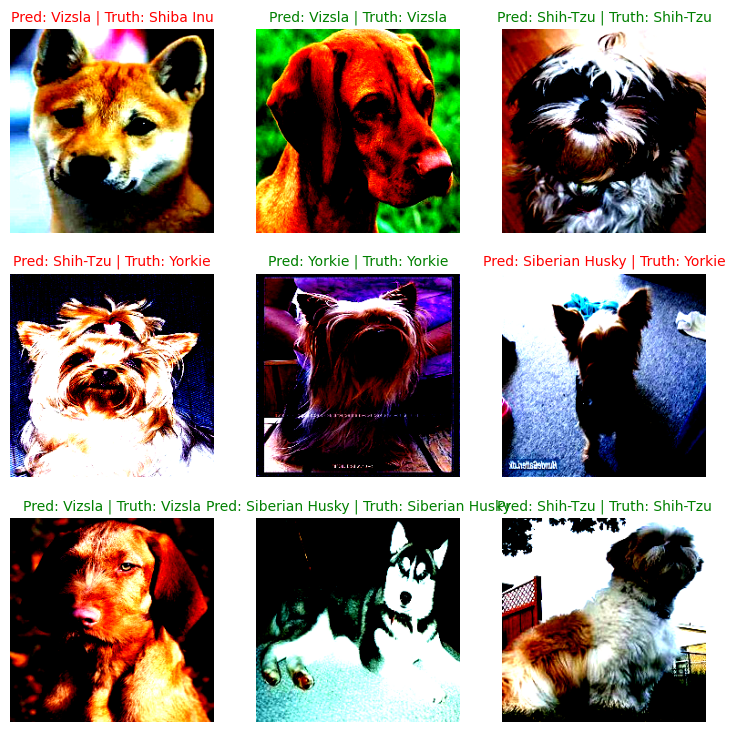

In [250]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  
  plt.subplot(nrows, ncols, i+1)


  plt.imshow(sample.squeeze().permute(1, 2, 0), cmap="gray")


  pred_label = class_names[pred_classes[i]]


  truth_label = class_names[test_labels[i]] 

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  

  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") 
  else:
      plt.title(title_text, fontsize=10, c="r") 
  plt.axis(False);